In [18]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

sample_height = 80
sample_width = 60

def draw_rect(frame):
    rows, cols, _ = frame.shape
    
    cv2.rectangle(frame, (int(rows/2 - sample_width/2), int(cols/2 - sample_height/2)), 
                  (int(rows/2 + sample_width/2), int(cols/2 + sample_height/2)),
                  (0, 0, 255), 1)
    return frame

def hand_histogram(frame):
    rows, cols, _ = frame.shape
    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    roi = np.zeros((sample_width, sample_height, 3), dtype=hsv_frame.dtype)
    
    roi[:] = hsv_frame[int(rows/2 - sample_width/2):int(rows/2 + sample_width/2),
                       int(cols/2 - sample_height/2):int(cols/2 + sample_height/2)]
    
    hand_hist = cv2.calcHist([roi], [0, 1], None, [180, 256], [0, 180, 0, 256])
    return cv2.normalize(hand_hist, hand_hist, 0, 255, cv2.NORM_MINMAX)

def hist_mask(frame, hist):
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    dst = cv2.calcBackProject([hsv], [0, 1], hist, [0, 180, 0, 256], 1)
    
    disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (31, 31))
    cv2.filter2D(dst, -1, disc, dst)
    
    ret, thresh = cv2.threshold(dst, 150, 255, cv2.THRESH_BINARY)
    
    thresh = cv2.merge((thresh, thresh, thresh))
    
    return thresh

def contours(hist_mask_image):
    gray_hist_mask_image = cv2.cvtColor(hist_mask_image, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray_hist_mask_image, 0, 255, 0)
    cont, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return cont

def max_contour(contour_list):
    max_i = 0
    max_area = 0

    for i in range(len(contour_list)):
        cnt = contour_list[i]
        area_cnt = cv2.contourArea(cnt)
        if area_cnt > max_area:
            max_area = area_cnt
            max_i = i

    return contour_list[max_i]

def centroid(max_contour):
    moment = cv2.moments(max_contour)
    if moment['m00'] != 0:
        cx = int(moment['m10'] / moment['m00'])
        cy = int(moment['m01'] / moment['m00'])
        return cx, cy
    else:
        return None

In [2]:
import os
import pickle

def next_file_num(path: str, file_type: str, beg: str) -> int:
    files = [f.replace(file_type,'').replace(beg,'') for f in os.listdir(path)]
    files_as_nums = [int(n) for n in files if n.isdigit()]
    return 0 if not files_as_nums else max(files_as_nums) + 1

In [16]:
cap = cv2.VideoCapture(0)

while cap.isOpened():
    _, frame = cap.read()
    key = cv2.waitKey(1)
    
    if key & 0xFF == ord('z'):
        hand_hist = hand_histogram(frame)
        mask = hist_mask(frame, hand_hist)
        masked_image = cv2.bitwise_and(frame, mask)

        next_num = next_file_num('sample_hand_hists','.jpg','hist_')

        cv2.imwrite('sample_frames/frame_{}.jpg'.format(next_num),frame)
        cv2.imwrite('sample_hand_hists/hist_{}.jpg'.format(next_num),masked_image)
        f = open('sample_hand_hists/hist_{}.pckl'.format(next_num),'wb')
        pickle.dump((hand_hist),f)
        f.close()
    else:
        frame = draw_rect(frame)
    
    if key & 0xFF == ord('q'):
        break

    cv2.imshow('frame', frame)
    

cap.release()
cv2.destroyAllWindows()

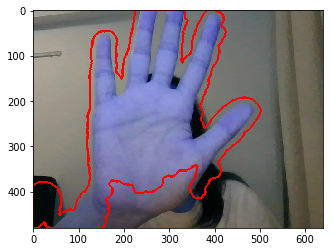

In [15]:
### for testing only
f = open('sample_hand_hists/hist_5.pckl','rb')
hand_hist = pickle.load(f)
f.close()
frame = cv2.imread('sample_frames/frame_5.jpg')

mask = hist_mask(frame, hand_hist)
masked_image = cv2.bitwise_and(frame, mask)

cont_list = contours(masked_image)

imgray = cv2.cvtColor(mask,cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(imgray,127,255,0)
cont_list_2, _ = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

max_cont = max_contour(cont_list)
max_cont_2 = max_contour(cont_list_2)


cv2.drawContours(frame, [max_cont_2], 0, (0,255,0), 3)
cv2.drawContours(frame, [max_cont], 0, (255,0,0), 3)
plt.imshow(frame)
plt.show()

In [17]:
f = open('sample_hand_hists/hist_26.pckl','rb')
hand_hist = pickle.load(f)
f.close()

cap = cv2.VideoCapture(0)

while cap.isOpened():
    _, frame = cap.read()
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
    else:
        mask = hist_mask(frame, hand_hist)

        gray_mask = cv2.cvtColor(mask,cv2.COLOR_BGR2GRAY)
        ret,thresh = cv2.threshold(gray_mask,127,255,0)
        cont_list, _ = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            max_cont = max_contour(cont_list)

            cnt_centroid = centroid(max_cont)
            cv2.circle(frame, cnt_centroid, 5, [255, 0, 0], -1)
        
    cv2.imshow('frame', frame)
    

cap.release()
cv2.destroyAllWindows()